<img src="https://www.collinsdictionary.com/images/full/xray_560923156_1000.jpg" width="320" height="180" align="center"/>

<br>
<h1 style = "font-size:30px; font-weight : bold; color : purple; text-align: center; border-radius: 10px 15px;">Pneumonia Detection Using X-Ray Images</h1>
<br>

---

# Overview

The goal of this notebook is to use Transfer Learning based CNN models on Chest X-Ray images to identify pneumonia or healthy lungs in patients. 

Used dataset: https://www.kaggle.com/datasets/tolgadincer/labeled-chest-xray-images

In this dataset, we have one folder with the train set and one for the test set. The train folder is later split in the notebook into train/validation sets.

# Importing Packages

In [1]:
import pandas as pd       
import matplotlib as mat
import matplotlib.pyplot as plt    
import numpy as np
import seaborn as sns
%matplotlib inline

pd.options.display.max_colwidth = 100

import random
import os

from numpy.random import seed
seed(42)

random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import cv2

from tensorflow.random import set_seed
set_seed(42)

import warnings
warnings.filterwarnings('ignore')

In [2]:
IMG_SIZE = 224
BATCH = 32
SEED = 42

# Data Augmentation
We identified a class imbalance between 'healthy' vs. 'pneumonia' data. We use a data augmentation function to generate new instances of the 'healthy' class, and we store them in the data directories, before continuing the data processing. 

NOTE: this function need to be run only once, as this will write the files to the directory, which can after that be used in further data processing.

In [ ]:
import Augmentor

# Function to augment the healthy data and store the files before
# note: this writes the files to specified folder - run only once!

def augment_healthy_data():

    cwd = os.getcwd()

    main_path = "chest_xray"
    train_path = os.path.join(main_path, "train")
    train_normal_path = os.path.join(train_path, "NORMAL")
    
    path = os.path.join(cwd, train_normal_path) # directory for train set healthy

    print(path)
    print("path exists: ", os.path.exists(path))

    p = Augmentor.Pipeline(path)

    # Add data augmentation operations and write images to directory
    p.rotate(probability=1, max_left_rotation=2, max_right_rotation=2)
    # p.skew(probability=0.2, magnitude=1)
    p.random_distortion(probability=0.5, grid_width=100, grid_height=100, magnitude=2)
    p.shear(probability=0.2, max_shear_left=1, max_shear_right=1)
    p.zoom_random(probability=0.3, percentage_area=0.98)
    p.sample(2500)
    
    print("Augmented files written to folder: ", os.path.join(path, "output"))


# Importing Dataset and Dataframe loading

In [3]:
# define data paths

main_path = "chest_xray"

train_path = os.path.join(main_path, "train")
test_path=os.path.join(main_path, "test")

train_normal = glob.glob(train_path + "/NORMAL/*.jpeg")
train_pneumonia = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

test_normal = glob.glob(test_path + "/NORMAL/*.jpeg")
test_pneumonia = glob.glob(test_path + "/PNEUMONIA/*.jpeg")

os.path.exists(main_path)

True

In [4]:
# process data classes and filepaths into dataframe
train_list = [x for x in train_normal]
train_list.extend([x for x in train_pneumonia])

df_train = pd.DataFrame(np.concatenate([['Normal']*len(train_normal) , ['Pneumonia']*len(train_pneumonia)]), columns = ['class'])
df_train['image'] = [x for x in train_list]

test_list = [x for x in test_normal]
test_list.extend([x for x in test_pneumonia])

df_test = pd.DataFrame(np.concatenate([['Normal']*len(test_normal) , ['Pneumonia']*len(test_pneumonia)]), columns = ['class'])
df_test['image'] = [x for x in test_list]

In [5]:
df_train # show training data dataframe

,class,image
0,Normal,chest_xray/train/NORMAL/NORMAL-2552119-0002.jpeg
1,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-155211-0001.jpeg_4d1870ea-74dc-4bc0-8c1c-87532334...
2,Normal,chest_xray/train/NORMAL/NORMAL-7298141-0001.jpeg
3,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-8040230-0001.jpeg_c0c56064-043c-4a8c-a1c0-bb313cf...
4,Normal,chest_xray/train/NORMAL/NORMAL-3411116-0002.jpeg
...,...,...
7727,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-3395038-0001.jpeg
7728,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-6952717-0001.jpeg
7729,Pneumonia,chest_xray/train/PNEUMONIA/VIRUS-463487-0002.jpeg
7730,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-4343805-0001.jpeg


In [6]:
df_test # show testing data dataframe

,class,image
0,Normal,chest_xray/test/NORMAL/NORMAL-8698006-0001.jpeg
1,Normal,chest_xray/test/NORMAL/NORMAL-5083836-0001.jpeg
2,Normal,chest_xray/test/NORMAL/NORMAL-5789014-0001.jpeg
3,Normal,chest_xray/test/NORMAL/NORMAL-4196521-0001.jpeg
4,Normal,chest_xray/test/NORMAL/NORMAL-6503977-0001.jpeg
...,...,...
619,Pneumonia,chest_xray/test/PNEUMONIA/BACTERIA-9242636-0001.jpeg
620,Pneumonia,chest_xray/test/PNEUMONIA/BACTERIA-1602272-0003.jpeg
621,Pneumonia,chest_xray/test/PNEUMONIA/VIRUS-4360206-0001.jpeg
622,Pneumonia,chest_xray/test/PNEUMONIA/VIRUS-3746644-0001.jpeg


In [86]:
print(len(df_train['image'][0]))

48


# Data Exploration

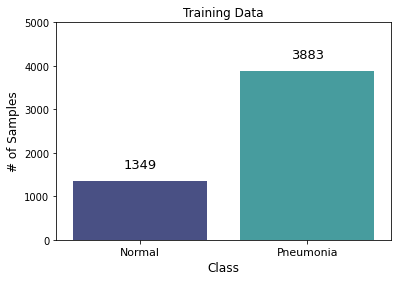

In [91]:
# get the original data (identified by the length of the file name)
df_train_original = df_train
df_train_original = df_train_original.drop(df_train_original[df_train_original['image'].map(len) > 80].index)

plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train_original, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
plt.title("Training Data")

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

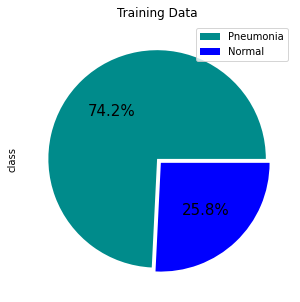

In [93]:
plt.figure(figsize=(7,5))

df_train_original['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title("Training Data")
plt.show()

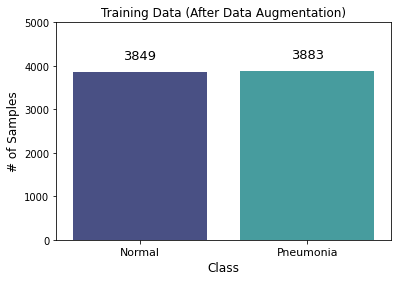

In [92]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_train, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,5000)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
plt.title("Training Data (After Data Augmentation)")

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)
    
plt.show()

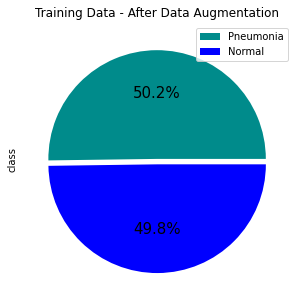

In [11]:
plt.figure(figsize=(7,5))

df_train['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title("Training Data (After Data Augmentation)")
plt.show()

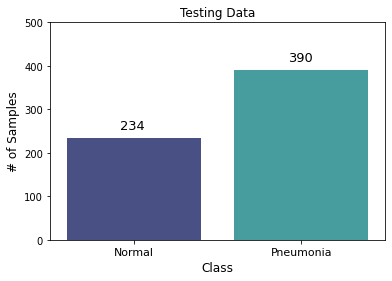

In [12]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x='class', data=df_test, palette="mako")

plt.xlabel("Class", fontsize= 12)
plt.ylabel("# of Samples", fontsize= 12)
plt.ylim(0,500)
plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
plt.title("Testing Data")

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.32, p.get_height()+20), fontsize = 13)
    
plt.show()

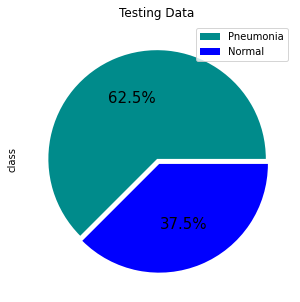

In [13]:
plt.figure(figsize=(7,5))

df_test['class'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['darkcyan','blue'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['Pneumonia', 'Normal'])
plt.title("Testing Data")

plt.show()

Train Set - Normal


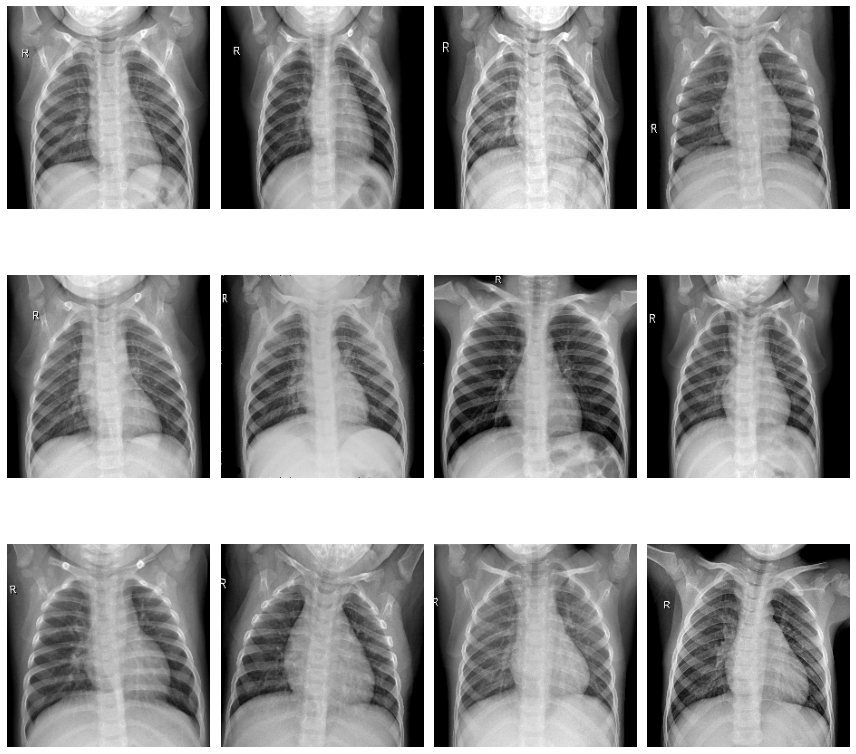

In [16]:
print('Train Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")


plt.tight_layout()

plt.show()


Train Set - Pneumonia


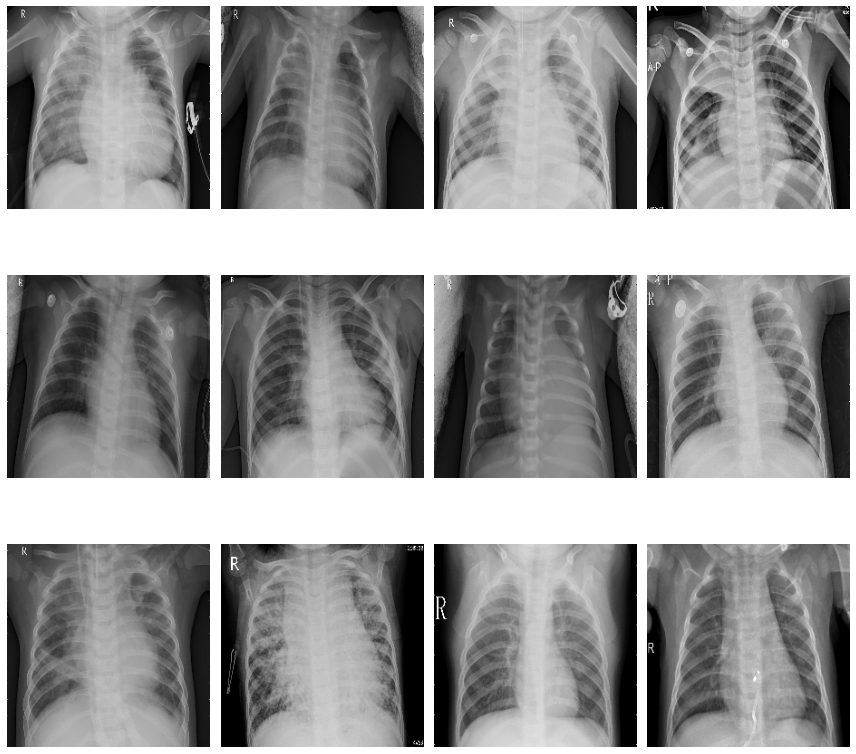

In [18]:
print('Train Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Normal


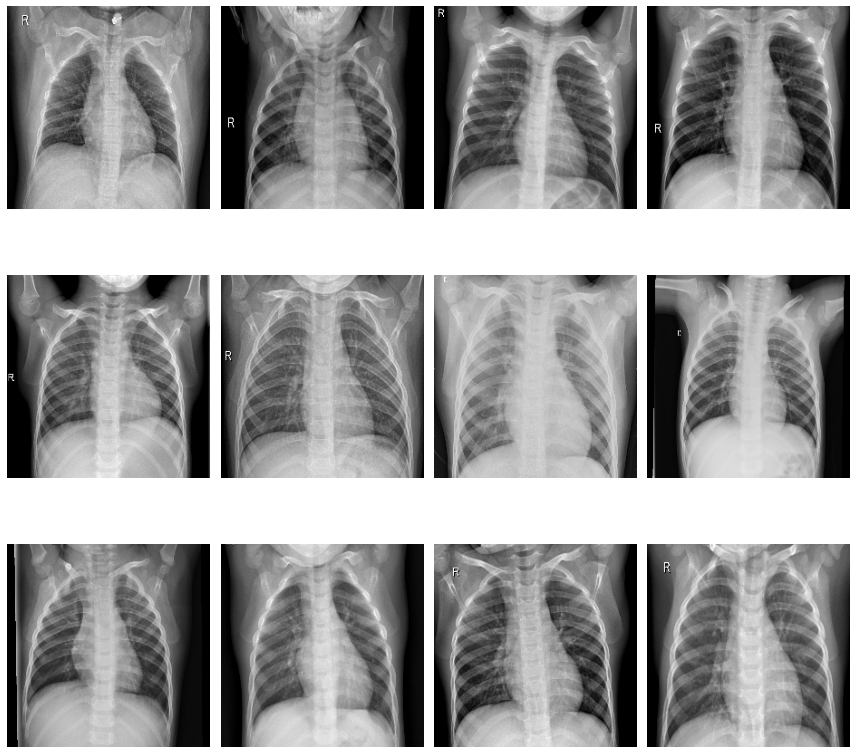

In [19]:
print('Test Set - Normal')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

Test Set - Pneumonia


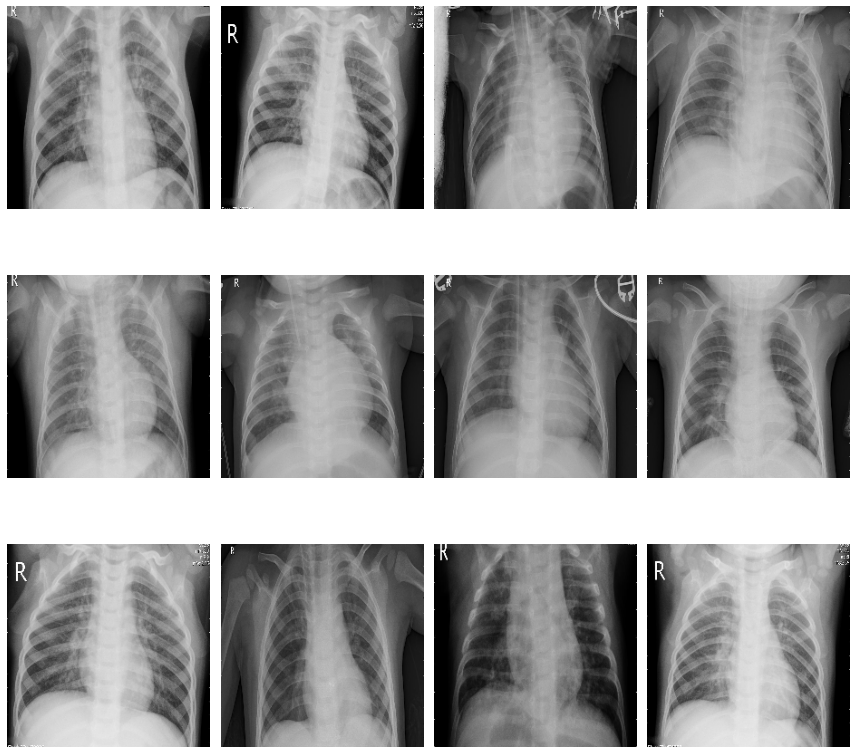

In [20]:
print('Test Set - Pneumonia')

plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(test_pneumonia[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()

plt.show()

# Histogram inspection

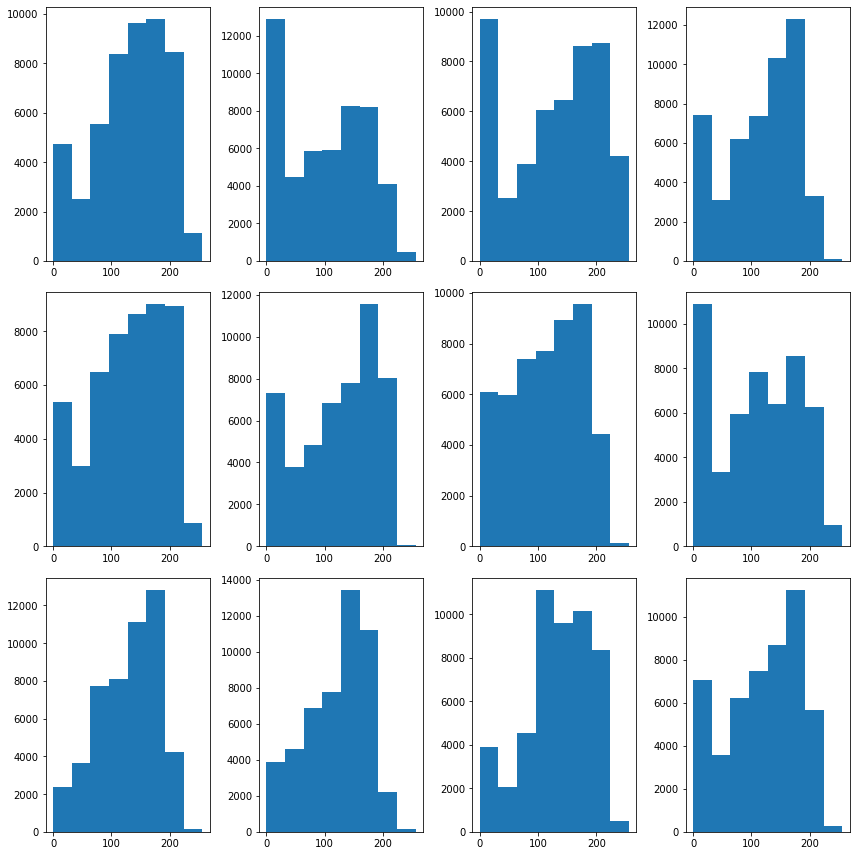

In [14]:
# inspect some histograms for the training data
print('Train Set - Normal')
plt.figure(figsize=(12,12))

for i in range(0, 12):
    plt.subplot(3,4,i + 1)
    img = cv2.imread(train_normal[i])
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    
    img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plt.hist(img_grey.ravel(),8,[0,256]) 
                  
plt.tight_layout()
    
plt.show()

In [ ]:
def normalize(x, newRange=(0, 1)): 
    xmin, xmax = np.min(x), np.max(x) #get max and min from pixel vals
    norm = (x - xmin)/(xmax - xmin) # scale
    
    if newRange == (0, 1):
        return(norm)
    elif newRange != (0, 1):
        return norm * (newRange[1] - newRange[0]) + newRange[0] #scale to range


## Old code for histogram transformations and inspection 

In [95]:
run = False

if run:
    index = random.randint(0, len(train_list)-1)
    num = 1

    img_plotting = True
    normalize = False
    equalize = False
    histogram = False
    write = False

    for image in train_list[index:index+num]:
        load_img = cv2.imread(image) 
        print("loaded image:", image)
        if img_plotting:
            plt.imshow(load_img)
            plt.show()

        if histogram:
            hist_8 = cv2.calcHist([load_img], [0], None, [8], [0, 256]) # 8 bins
            # plot the histogram
            if img_plotting:
                plt.figure()
                plt.plot(hist_8)
                plt.show()

        if normalize:
            new_path_hist = image.replace("NORMAL", "NORMAL_HIST").replace("PNEUMONIA", "PNEUMONIA_HIST")
            print("normalized image path: ", new_path_hist)

            img_normalized = cv2.normalize(load_img, None, 0, 255, cv2.NORM_MINMAX)

            if write:
                print("implement writing function")
                pass

            if img_plotting:
                plt.imshow(img_normalized)
                plt.show()
            if histogram:
                hist_8 = cv2.calcHist([img_normalized], [0], None, [8], [0, 256]) # 8 bins
                # plot the histogram
                if img_plotting:
                    plt.figure()
                    plt.plot(hist_8)
                    plt.show()


        if equalize:
            new_path_eq = image.replace("NORMAL", "NORMAL_EQ").replace("PNEUMONIA", "PNEUMONIA_EQ")
            print("equalized image path: ", new_path_eq)

            # convert from RGB color-space to YCrCb
            ycrcb_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2YCrCb)

            # equalize the histogram of the Y channel
            ycrcb_img[:, :, 0] = cv2.equalizeHist(ycrcb_img[:, :, 0])

            # convert back to RGB color-space from YCrCb
            img_equalized = cv2.cvtColor(ycrcb_img, cv2.COLOR_YCrCb2BGR)

            if write:
                cv2.imwrite(filename=new_path_eq, 
                            image=img_equalized)

            if img_plotting:
                plt.imshow(img_equalized)
                plt.show()
            if histogram:
                hist_8 = cv2.calcHist([img_equalized], [0], None, [8], [0, 256]) # 8 bins
                # plot the histogram
                if img_plotting:
                    plt.figure()
                    plt.plot(hist_8)
                    plt.show()

        print("min max: ", np.min(load_img), np.max(load_img), "changed to:", np.min(img_normalized), np.max(img_normalized))

        print("pixel values identical: ", np.all(load_img==img_equalized), "\n")
        print("path identical: ", image==new_path_eq, "\n")
    

In [ ]:
run = False

if run:
    total = len(train_list)
    count = 0

    img_plotting = False

    for idx, image in enumerate(train_list):

        if idx % 1000 == 0:
            print("images checked: ", idx)

        load_img = cv2.imread(image) 

        if img_plotting:
            plt.imshow(load_img)
            plt.show()

        hist_8 = cv2.calcHist([load_img], [0], None, [8], [0, 256]) # 8 bins
        # plot the histogram
        if img_plotting:
            plt.figure()
            plt.plot(hist_8)
            plt.show()

        new_path = image.replace("NORMAL", "NORMAL_HIST").replace("PNEUMONIA", "PNEUMONIA_HIST")

        img_normalized = cv2.normalize(load_img, None, 0, 255, cv2.NORM_MINMAX)
        if img_plotting:
            plt.imshow(img_normalized)
            plt.show()

        hist_8 = cv2.calcHist([img_normalized], [0], None, [8], [0, 256]) # 8 bins
        # plot the histogram
        if img_plotting:
            plt.figure()
            plt.plot(hist_8)
            plt.show()

        if not np.all(load_img==img_normalized):
            count += 1

        if new_path == image:
            print("Error: paths identical")
            break

    print("\nimages not identical: {} out of {}".format(count, total))  

# Process and prepare data for model training

In [21]:
# split training data into train and validation set
train_df, val_df = train_test_split(df_train, test_size = 0.20, random_state = SEED, stratify = df_train['class'])

In [101]:
train_df # show training data dataframe

,class,image
2592,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-508988-0001.jpeg_cd4a23af-9ca8-40eb-ac1f-76f03794...
6955,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-4599282-0001.jpeg
5910,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-8738712-0010.jpeg
2943,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-6126748-0001.jpeg_2ab964ea-ef68-4370-9c55-45aa779...
1771,Normal,chest_xray/train/NORMAL/NORMAL-6524946-0001.jpeg
...,...,...
3548,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-7019096-0003.jpeg_28572bc9-feb5-4e4f-aebd-76e094b...
4295,Pneumonia,chest_xray/train/PNEUMONIA/VIRUS-6709337-0001.jpeg
5196,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-5626093-0005.jpeg
621,Normal,chest_xray/train/NORMAL/NORMAL-3964800-0002.jpeg


In [108]:
plot = False
print("train_df plot: ", plot)

if plot:

    plt.figure(figsize=(6,4))

    ax = sns.countplot(x='class', data=train_df, palette="mako")

    plt.xlabel("Class", fontsize= 12)
    plt.ylabel("# of Samples", fontsize= 12)
    plt.ylim(0,5000)
    plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
    plt.title("Training Data after validation split")

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

    plt.show()

train_df plot:  False


In [103]:
val_df # show validation data dataframe

,class,image
6625,Pneumonia,chest_xray/train/PNEUMONIA/VIRUS-8498536-0002.jpeg
7148,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-2609929-0003.jpeg
3087,Normal,chest_xray/train/NORMAL/NORMAL-9487573-0001.jpeg
7414,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-5044617-0002.jpeg
1478,Normal,chest_xray/train/NORMAL/NORMAL_original_NORMAL-3103404-0002.jpeg_5d9fcf75-b72a-4842-8479-143883c...
...,...,...
3002,Normal,chest_xray/train/NORMAL/NORMAL-9985167-0001.jpeg
5276,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-8426593-0001.jpeg
5077,Pneumonia,chest_xray/train/PNEUMONIA/VIRUS-3303372-0002.jpeg
4607,Pneumonia,chest_xray/train/PNEUMONIA/BACTERIA-6775167-0001.jpeg


In [111]:
plot = False
print("val_df plot: ", plot)

if plot:
    
    plt.figure(figsize=(6,4))

    ax = sns.countplot(x='class', data=val_df, palette="mako")

    plt.xlabel("Class", fontsize= 12)
    plt.ylabel("# of Samples", fontsize= 12)
    plt.ylim(0,5000)
    plt.xticks([0,1], ['Normal', 'Pneumonia'], fontsize = 11)
    plt.title("Validation data")

    for p in ax.patches:
        ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 13)

    plt.show()

val_df plot:  False


In [25]:
# intitialize data generators for data passing

# apply pixel normalization and additional data augmentation for the train set
train_datagen = ImageDataGenerator(rescale=1/255.,
                                   zoom_range = 0.05,
                                   rotation_range = 2, #2 degrees rotation
                                   brightness_range=(0.95, 1.05),
                                   horizontal_flip=False,
                                   vertical_flip=False,
                                   width_shift_range = 0.03,
                                   height_shift_range = 0.03)

# pixel normalization only (without augmentation) for val/test set
val_datagen = ImageDataGenerator(rescale=1/255.)

ds_train = train_datagen.flow_from_dataframe(train_df,
                                             x_col = 'image',
                                             y_col = 'class',
                                             target_size = (IMG_SIZE, IMG_SIZE),
                                             class_mode = 'binary',
                                             batch_size = BATCH,
                                             seed = SEED)

ds_val = val_datagen.flow_from_dataframe(val_df,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = BATCH,
                                            seed = SEED)

ds_test = val_datagen.flow_from_dataframe(df_test,
                                            x_col = 'image',
                                            y_col = 'class',
                                            target_size = (IMG_SIZE, IMG_SIZE),
                                            class_mode = 'binary',
                                            batch_size = 1,
                                            shuffle = False)

Found 6185 validated image filenames belonging to 2 classes.
Found 1547 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


# Parameter Setting

In [26]:
# define callbacks for training

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    min_delta=1e-7,
    restore_best_weights=True,
)

plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor = 0.2,                                     
    patience = 2,                                   
    min_delt = 1e-7,                                
    cooldown = 0,                               
    verbose = 1
) 

# Model Training (Transfer Learning)

In [34]:
# Load pretrained DenseNet201 (imagenet) weights from keras without top/head

base_model = tf.keras.applications.DenseNet201(
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False)

# Freeze the weights of the base model
base_model.trainable = False

# Combine the backbone with new head and output layers
def build_pretrained():
    
    # Input shape = [width, height, color channels]
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    # Get DenseNet layers
    x = base_model(inputs)

    # Add Head layers
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.1)(x)
    
    # Final (Output) layer 
    output = layers.Dense(1, activation='sigmoid')(x) # sigmoid with 1 node for binary classification
    
    model = keras.Model(inputs=[inputs], outputs=output)
    
    return model

In [35]:
# base_model.summary()

In [94]:
keras.backend.clear_session()

In [39]:
# Make model layers trainable
base_model.trainable = True

# Freeze model params except for the last 30 DenseNet layers
for layer in base_model.layers[:-30]:
    layer.trainable = False

In [40]:
# Show which layers in the model are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable)

0 input_4 False
1 zero_padding2d_2 False
2 conv1/conv False
3 conv1/bn False
4 conv1/relu False
5 zero_padding2d_3 False
6 pool1 False
7 conv2_block1_0_bn False
8 conv2_block1_0_relu False
9 conv2_block1_1_conv False
10 conv2_block1_1_bn False
11 conv2_block1_1_relu False
12 conv2_block1_2_conv False
13 conv2_block1_concat False
14 conv2_block2_0_bn False
15 conv2_block2_0_relu False
16 conv2_block2_1_conv False
17 conv2_block2_1_bn False
18 conv2_block2_1_relu False
19 conv2_block2_2_conv False
20 conv2_block2_concat False
21 conv2_block3_0_bn False
22 conv2_block3_0_relu False
23 conv2_block3_1_conv False
24 conv2_block3_1_bn False
25 conv2_block3_1_relu False
26 conv2_block3_2_conv False
27 conv2_block3_concat False
28 conv2_block4_0_bn False
29 conv2_block4_0_relu False
30 conv2_block4_1_conv False
31 conv2_block4_1_bn False
32 conv2_block4_1_relu False
33 conv2_block4_2_conv False
34 conv2_block4_concat False
35 conv2_block5_0_bn False
36 conv2_block5_0_relu False
37 conv2_block5_

532 conv5_block8_1_conv False
533 conv5_block8_1_bn False
534 conv5_block8_1_relu False
535 conv5_block8_2_conv False
536 conv5_block8_concat False
537 conv5_block9_0_bn False
538 conv5_block9_0_relu False
539 conv5_block9_1_conv False
540 conv5_block9_1_bn False
541 conv5_block9_1_relu False
542 conv5_block9_2_conv False
543 conv5_block9_concat False
544 conv5_block10_0_bn False
545 conv5_block10_0_relu False
546 conv5_block10_1_conv False
547 conv5_block10_1_bn False
548 conv5_block10_1_relu False
549 conv5_block10_2_conv False
550 conv5_block10_concat False
551 conv5_block11_0_bn False
552 conv5_block11_0_relu False
553 conv5_block11_1_conv False
554 conv5_block11_1_bn False
555 conv5_block11_1_relu False
556 conv5_block11_2_conv False
557 conv5_block11_concat False
558 conv5_block12_0_bn False
559 conv5_block12_0_relu False
560 conv5_block12_1_conv False
561 conv5_block12_1_bn False
562 conv5_block12_1_relu False
563 conv5_block12_2_conv False
564 conv5_block12_concat False
565 con

In [41]:
# Get model and compile with binary loss and Adam optimizer
model_pretrained = build_pretrained()

model_pretrained.compile(loss='binary_crossentropy', 
                         optimizer = keras.optimizers.Adam(learning_rate=2e-6), 
                         metrics='binary_accuracy')

model_pretrained.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d (G  (None, 1920)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               245888    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                             

In [68]:
# fit model 100 epochs with earlystopping and plateau callbacks
history = model_pretrained.fit(ds_train,
          batch_size = BATCH,
          epochs = 100,
          validation_data=ds_val,
          callbacks=[early_stopping, plateau],
          steps_per_epoch=(len(train_df)/BATCH),
          validation_steps=(len(val_df)/BATCH));

# output shows continued training of 40 epochs after already training 60 epochs without fully converging

Epoch 1/40
193/193 [==============================] - 1225s 6s/step - loss: 0.0485 - binary_accuracy: 0.9846 - val_loss: 0.0435 - val_binary_accuracy: 0.9838 - lr: 2.0000e-06
Epoch 2/40
193/193 [==============================] - 1237s 6s/step - loss: 0.0494 - binary_accuracy: 0.9863 - val_loss: 0.0425 - val_binary_accuracy: 0.9851 - lr: 2.0000e-06
Epoch 3/40
193/193 [==============================] - 1238s 6s/step - loss: 0.0470 - binary_accuracy: 0.9858 - val_loss: 0.0425 - val_binary_accuracy: 0.9845 - lr: 2.0000e-06
Epoch 4/40
193/193 [==============================] - 1240s 6s/step - loss: 0.0471 - binary_accuracy: 0.9851 - val_loss: 0.0417 - val_binary_accuracy: 0.9851 - lr: 2.0000e-06
Epoch 5/40
193/193 [==============================] - 1239s 6s/step - loss: 0.0468 - binary_accuracy: 0.9859 - val_loss: 0.0408 - val_binary_accuracy: 0.9858 - lr: 2.0000e-06
Epoch 6/40
193/193 [==============================] - 1239s 6s/step - loss: 0.0431 - binary_accuracy: 0.9869 - val_loss: 0.04

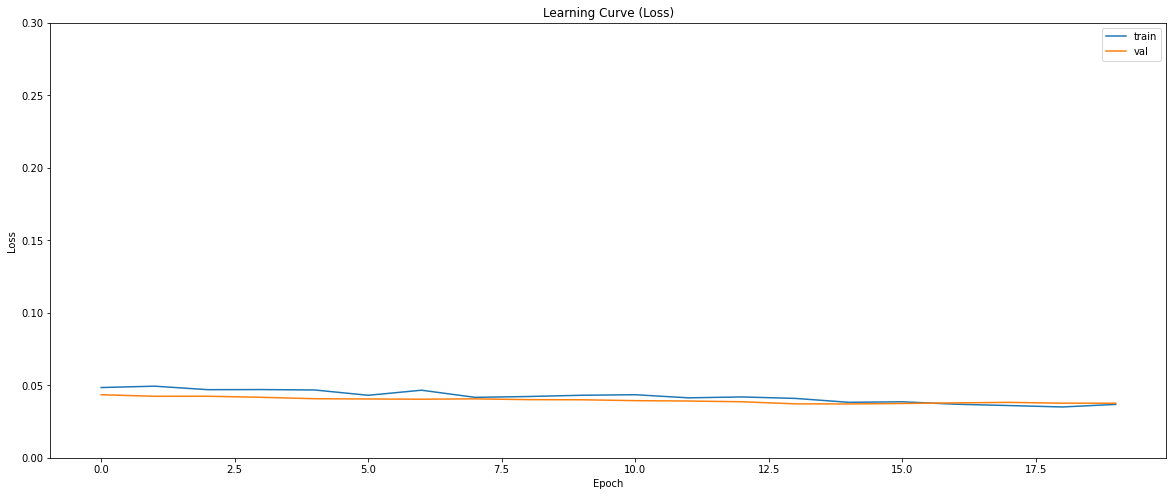

In [69]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['loss'])
sns.lineplot(x = history.epoch, y = history.history['val_loss'])
ax.set_title('Learning Curve (Loss)')
ax.set_ylabel('Loss')
ax.set_xlabel('Epoch')
ax.set_ylim(0, 0.3)
ax.legend(['train', 'val'], loc='best')
plt.show()

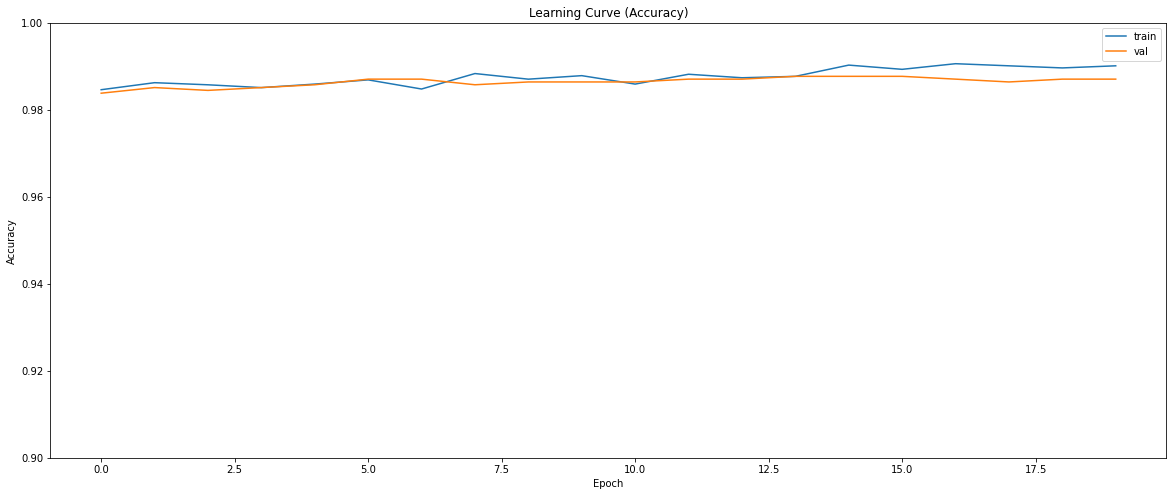

In [70]:
fig, ax = plt.subplots(figsize=(20,8))
sns.lineplot(x = history.epoch, y = history.history['binary_accuracy'])
sns.lineplot(x = history.epoch, y = history.history['val_binary_accuracy'])
ax.set_title('Learning Curve (Accuracy)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylim(0.90, 1.0)
ax.legend(['train', 'val'], loc='best')
plt.show()

In [71]:
score = model_pretrained.evaluate(ds_val, steps = len(val_df)/BATCH, verbose = 0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.03714454919099808
Val accuracy: 0.9877181649208069


In [72]:
score = model_pretrained.evaluate(ds_test, steps = len(df_test), verbose = 0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11862766742706299
Test accuracy: 0.9583333134651184


In [73]:
# save model weights after training

save_pretrained = True

if save_pretrained:
    model_pretrained.save('model_weights/20230610_model_pretrained_DenseNet_30layers')

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Constant'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


# Performance Metrics

In [74]:
num_label = {'Normal': 0, 'Pneumonia' : 1}
Y_test = df_test['class'].copy().map(num_label).astype('int')

In [75]:
ds_test.reset()
predictions = model_pretrained.predict(ds_test, steps=len(ds_test), verbose=0)
pred_labels = np.where(predictions>0.5, 1, 0)

In [76]:
print("Test Accuracy: ", accuracy_score(Y_test, pred_labels))

Test Accuracy:  0.9583333333333334


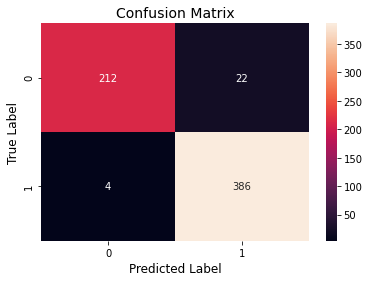

In [96]:
# Compute and plot confusion matrix
confusion_matrix = metrics.confusion_matrix(Y_test, pred_labels)
sns.heatmap(confusion_matrix, annot=True, fmt="d")

plt.title("Confusion Matrix", fontsize= 14)

plt.xlabel("Predicted Label", fontsize= 12)
plt.ylabel("True Label", fontsize= 12)

plt.show()

In [78]:
print(metrics.classification_report(Y_test, pred_labels, labels = [0, 1]))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       234
           1       0.95      0.99      0.97       390

    accuracy                           0.96       624
   macro avg       0.96      0.95      0.95       624
weighted avg       0.96      0.96      0.96       624



ROC_AUC:  0.9916173570019724


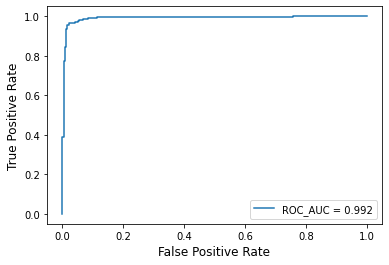

In [79]:
roc_auc = metrics.roc_auc_score(Y_test, predictions)
print('ROC_AUC: ', roc_auc)

fpr, tpr, thresholds = metrics.roc_curve(Y_test, predictions)

plt.plot(fpr, tpr, label = 'ROC_AUC = %0.3f' % roc_auc)

plt.xlabel("False Positive Rate", fontsize= 12)
plt.ylabel("True Positive Rate", fontsize= 12)
plt.legend(loc="lower right")

plt.show()